In [1]:
pip install tensorflow opencv-python numpy pandas scikit-learn matplotlib



     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ------------------------- -------------- 30.7/48.7 kB ? eta -:--:--
     -------------------------------------- 48.7/48.7 kB 818.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/390.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/390.2 MB 2.0 MB/s eta 0:03:11
   ---------------------------------------- 0.1/390.2 MB 825.8 kB/s eta 0:07:53
   ---------------------------------------- 0.1/390.2 MB 1.1 MB/s eta 0:06:07
   ---------------------------------------- 0.2/390.2 MB 1.3 MB/s eta 0:04:57
   ---------------------------------------- 0.2/390.2 MB 1.0 MB/s eta 0:06:28
   ---------------------------------------- 0.3/390.2 MB 1.2 MB/s eta 0:05:37
   ---------------------------------------- 0.4/390.2 MB 1.1 MB/s eta 0:05:40
   ---------------------------------------- 0.5/390.2 MB 1.3 MB/s eta 0:05:04
   ---------------------------------------- 0.6/390.2 MB 1.3 MB/s eta 0:04:57

Loading dataset...
Loaded 2000 images and 2000 labels.
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.4611 - loss: 1.5655 - val_accuracy: 0.9975 - val_loss: 0.0186
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9739 - loss: 0.0964 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9843 - loss: 0.0467 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9904 - loss: 0.0269 - val_accuracy: 1.0000 - val_loss: 2.1072e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9961 - loss: 0.0135 - val_accuracy: 1.0000 - val_loss: 3.6362e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9985 - loss: 0.0098 - val_accuracy: 1.0000 - val_loss: 4.1781e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9975 - loss: 0.0141 - val_accuracy: 1.0000 - val_loss: 4.7133e-05
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s

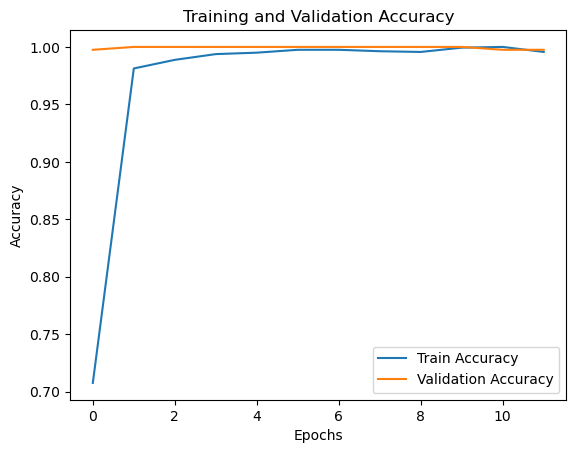

Model saved as gesture_recognition_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


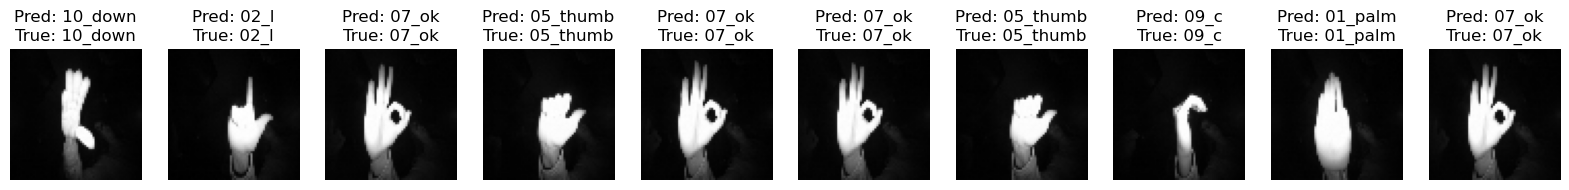

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Set paths
DATASET_DIR = r"C:\Users\omcha\Machine learning\Task4\leapGestRecog\\00"  # Replace with the correct dataset path

# Image size (resize for uniformity)
IMAGE_SIZE = (64, 64)

# Function to load dataset
def load_dataset(dataset_dir):
    images = []
    labels = []
    for gesture_folder in os.listdir(dataset_dir):
        gesture_path = os.path.join(dataset_dir, gesture_folder)
        if os.path.isdir(gesture_path):
            for filename in os.listdir(gesture_path):
                filepath = os.path.join(gesture_path, filename)
                try:
                    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
                    if img is not None:
                        img = cv2.resize(img, IMAGE_SIZE)
                        images.append(img)
                        labels.append(gesture_folder)
                except Exception as e:
                    print(f"Error loading image {filepath}: {e}")
    if len(images) == 0 or len(labels) == 0:
        raise ValueError("No data found. Check the dataset directory.")
    print(f"Loaded {len(images)} images and {len(labels)} labels.")
    return np.array(images), np.array(labels)

# Load data
print("Loading dataset...")
images, labels = load_dataset(DATASET_DIR)

# Normalize images
images = images / 255.0  # Normalize pixel values to [0, 1]

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_categorical, test_size=0.2, random_state=42
)
X_train = X_train.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Add channel dimension
X_test = X_test.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

# Build CNN model
model = Sequential([
    Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),  # Define input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Number of classes
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

# Save model in the recommended format
model.save("gesture_recognition_model.keras")
print("Model saved as gesture_recognition_model.keras")

# Visualize predictions
def visualize_predictions(X_test, y_test, num_samples=10):
    predictions = model.predict(X_test)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(X_test[i].reshape(IMAGE_SIZE[0], IMAGE_SIZE[1]), cmap='gray')
        pred_label = label_encoder.inverse_transform([np.argmax(predictions[i])])[0]
        true_label = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")
        ax.axis('off')
    plt.show()

visualize_predictions(X_test, y_test)
